In [1]:
%load_ext autoreload

import os
import sys
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import torch
import torch.nn as nn

module_path = os.path.abspath(os.path.join('../../py-conjugated/'))
if module_path not in sys.path:
    sys.path.append(module_path)
import morphology_networks as net
import model_training as train
import model_testing as test
import physically_informed_loss_functions as pilf
import network_utils as nuts

torch.manual_seed(28)

# This notebook seeks to use all OPV processing conditions and morphological descriptors to predict device performance. 

## There will be 3 Neural Networks outlined, each with similar architecture, but varying inputs. This first NN will only use processing conditions to try to predict performance

### Inputs:
- DataFrame containing device processing conditions and their subsequent performance. 

*_Note:_* This DataFrame will only contain devices with reasonable performance values.

### Outputs:
- Tensor of predicted performance for given processing conditions

In [2]:
#Take in data as a dataframe for easy preprocessing
device_df = pd.read_excel('/Users/wesleytatum/Desktop/py-conjugated/data/normed_OPV_device.xlsx')

test_df = pd.read_excel('/Users/wesleytatum/Desktop/py-conjugated/data/normed_OPV_test.xlsx')

print (f'device_df shape: {device_df.shape}')
print (f'test_df shape: {test_df.shape}')
device_df.head()

device_df shape: (366, 9)
test_df shape: (10, 60)


,Unnamed: 0,PCE,VocL,Jsc,FF,Substrate,Device,Time (min),Temp (C)
0,0,0.000000,0.000000,0.078981,0.066177,1,5,0,0
1,1,0.088229,1.000000,0.026882,0.000000,7,5,0,0
2,2,0.185014,0.934181,0.000000,0.565143,7,6,0,0
3,3,0.187694,0.915305,0.008375,0.570857,7,2,0,0
4,4,0.190771,0.928501,0.058959,0.436489,1,1,0,0


In [3]:
# Hyper parameters
num_epochs = 100
batch_size = int(len(device_df['PCE'])*0.8) # 80% of x_train samples
learning_rate = 0.000095

# Device configuration (GPU if available, otherwise CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
x_train = device_df[['Time (min)', 'Temp (C)']] #input features used to make prediction
y_train = device_df[['PCE', 'VocL', 'Jsc', 'FF']] #target features to be predicted

x_test = test_df[['Anneal_time', 'Anneal_temp']]
y_test = test_df[['PCE', 'VocL', 'Jsc', 'FF']]

In [5]:
pce_train = y_train['PCE']
pce_test = y_test['PCE']
voc_train = y_train['VocL']
voc_test = y_test['VocL']
jsc_train = y_train['Jsc']
jsc_test = y_test['Jsc']
ff_train = y_train['FF']
ff_test = y_test['FF']

x_train_tensor = torch.tensor(x_train.values.astype(np.float32)) #convert pd.DataFrame -> np.ndarray -> torch.tensor
pce_train_tensor = torch.tensor(pce_train.values.astype(np.float32))
voc_train_tensor = torch.tensor(voc_train.values.astype(np.float32))
jsc_train_tensor = torch.tensor(jsc_train.values.astype(np.float32))
ff_train_tensor = torch.tensor(ff_train.values.astype(np.float32))

#create tensor with features and targets
train_tensor = torch.utils.data.TensorDataset(x_train_tensor, pce_train_tensor, voc_train_tensor, jsc_train_tensor, ff_train_tensor)
#create iterable dataset with batches
training_data_set = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = True)

x_test_tensor = torch.tensor(x_test.values.astype(np.float32))
pce_test_tensor = torch.tensor(pce_test.values.astype(np.float32))
voc_test_tensor = torch.tensor(voc_test.values.astype(np.float32))
jsc_test_tensor = torch.tensor(jsc_test.values.astype(np.float32))
ff_test_tensor = torch.tensor(ff_test.values.astype(np.float32))

test_tensor = torch.utils.data.TensorDataset(x_test_tensor, pce_test_tensor, voc_test_tensor, jsc_test_tensor, ff_test_tensor)
testing_data_set = torch.utils.data.DataLoader(dataset = test_tensor, batch_size = batch_size, shuffle = True)

Now that the data, model, training, and evaluating are all set up, let's actually use everything

In [6]:
%autoreload

# Instantiate our beautiful NN model
# takes in 2 features (anneal time, anneal temp) 
# predicts 4 metrics (PCE, Voc, Jsc, FF)
in_dims = int(x_train_tensor.size(1)) #number of x channels
out_dims = y_test.shape[1] #number of predicted features

model = net.OPV_df_NN(in_dims = in_dims, out_dims = out_dims).to(device)
model.apply(nuts.init_weights)

#define the optimizer
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)

In [7]:
%autoreload

#empty list to hold loss per epoch
train_epoch_losses = []
pce_train_epoch_losses = []
voc_train_epoch_losses = []
jsc_train_epoch_losses = []
ff_train_epoch_losses = []

test_epoch_losses = []
pce_test_epoch_losses = []
voc_test_epoch_losses = []
jsc_test_epoch_losses = []
ff_test_epoch_losses = []

pce_test_epoch_accuracies = []
voc_test_epoch_accuracies = []
jsc_test_epoch_accuracies = []
ff_test_epoch_accuracies = []

save_epochs = np.arange(0, num_epochs, 5)

for epoch in range(num_epochs):
    print('On epoch ', epoch)
    
    save_dir = "/Users/wesleytatum/Desktop/model_states/OPV_NN1/"
    model_name = "OPV_NN1"
    model_path = save_dir+model_name+'*.pt'
    if epoch < 10:
        save_path = save_dir + model_name + '_epoch0' + str(epoch) + '.pt'
    else:
        save_path = save_dir + model_name + '_epoch' + str(epoch) + '.pt'
        
    if glob.glob(model_path) != []:
        model_states = glob.glob(model_path)
        model_states = sorted(model_states)
        previous_model = model_states[-1]
        
        model, optimizer = nuts.load_trained_model(previous_model, model, optimizer)
    
    model, train_loss, pce_train_loss, voc_train_loss, jsc_train_loss, ff_train_loss = train.train_OPV_df_model(model = model,
                                                                                                         training_data_set = training_data_set,
                                                                                                         optimizer = optimizer)
    train_epoch_losses.append(train_loss)
    pce_train_epoch_losses.append(pce_train_loss)
    voc_train_epoch_losses.append(voc_train_loss)
    jsc_train_epoch_losses.append(jsc_train_loss)
    ff_train_epoch_losses.append(ff_train_loss)
    
    test_loss, pce_test_loss, voc_test_loss, jsc_test_loss, ff_test_loss, pce_acc, voc_acc, jsc_acc, ff_acc = test.eval_OPV_df_model(model = model,
                                                                                                                                    testing_data_set = testing_data_set)
    test_epoch_losses.append(test_loss)
    pce_test_epoch_losses.append(pce_test_loss)
    voc_test_epoch_losses.append(voc_test_loss)
    jsc_test_epoch_losses.append(jsc_test_loss)
    ff_test_epoch_losses.append(ff_test_loss)
    
    pce_test_epoch_accuracies.append(pce_acc)
    voc_test_epoch_accuracies.append(voc_acc)
    jsc_test_epoch_accuracies.append(jsc_acc)
    ff_test_epoch_accuracies.append(ff_acc)
 
    nuts.save_trained_model(save_path, epoch, model, optimizer, train_loss, test_loss)

On epoch  0
Total Epoch Testing Loss = 0.16181054711341858
Total Epoch Testing MAPE: PCE = 65.78737623989582
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 66.47721759974957
On epoch  1


/Users/wesleytatum/Desktop/py-conjugated/py-conjugated_Github/py-conjugated/py-conjugated/physically_informed_loss_functions.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  error = torch.neg(torch.tensor(y))


Total Epoch Testing Loss = 0.20013272762298584
Total Epoch Testing MAPE: PCE = 56.15463137626649
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 51.66682849172503
On epoch  2
Total Epoch Testing Loss = 0.24436265230178833
Total Epoch Testing MAPE: PCE = 41.831105686724186
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 110.19257187843323
On epoch  3
Total Epoch Testing Loss = 0.6440712213516235
Total Epoch Testing MAPE: PCE = 42.83359117805958
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 187.64885425567627
On epoch  4
Total Epoch Testing Loss = 0.4090578258037567
Total Epoch Testing MAPE: PCE = 48.94502926617861
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 213.63744497299194
On epoch  5
Total Epoch Te

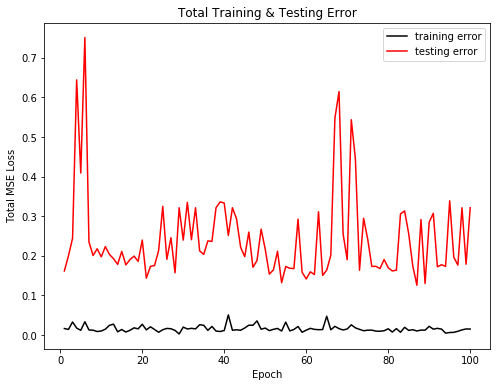

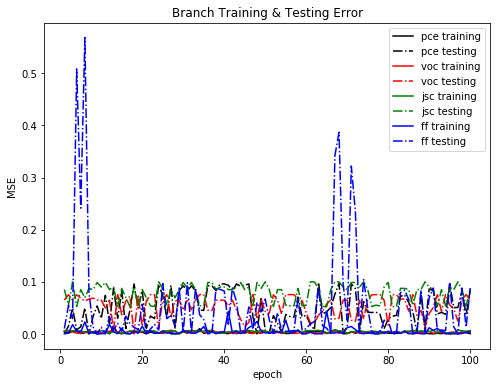

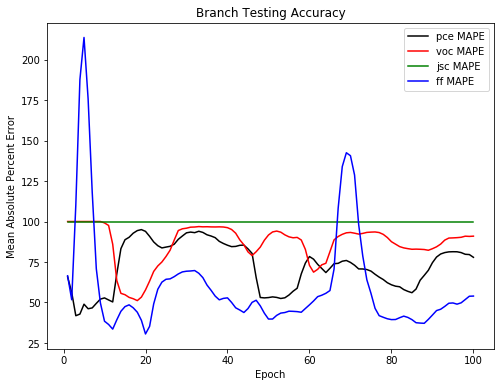

In [8]:
epochs = np.arange(1, (num_epochs+1), 1)

nuts.plot_OPV_df_loss(epochs, train_epoch_losses, test_epoch_losses,
                     pce_train_epoch_losses, pce_test_epoch_losses,
                     voc_train_epoch_losses, voc_test_epoch_losses,
                     jsc_train_epoch_losses, jsc_test_epoch_losses,
                     ff_train_epoch_losses, ff_test_epoch_losses)

nuts.plot_OPV_df_accuracies(epochs, pce_test_epoch_accuracies, voc_test_epoch_accuracies, 
                           jsc_test_epoch_accuracies, ff_test_epoch_accuracies)

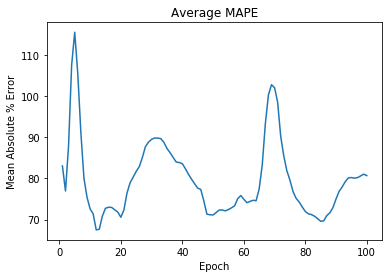

In [9]:
avg_acc = []
for p, v, j, f in zip(pce_test_epoch_accuracies, voc_test_epoch_accuracies,
                      jsc_test_epoch_accuracies, ff_test_epoch_accuracies):
    
    acc = (p+v+j+f)/4
    avg_acc.append(acc)
    
fig, ax = plt.subplots()
plt.plot(epochs, avg_acc)
plt.title('Average MAPE')
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Absolute % Error')
plt.show()

In [10]:
potential_models = avg_acc[:45]

min_mape = min(potential_models)

best_acc_indx = []
for acc in potential_models:
    if acc == min_mape:
        best_acc_indx.append(potential_models.index(acc))
    else:
        pass

In [14]:
if best_acc_indx[0] < 10:
    epoch = f'0{best_acc_indx[0]}'
else:
    epoch = f'{best_acc_indx[0]}'

print(epoch)

best_model_path = save_dir + model_name + '_epoch' + epoch + '.pt'
best_model = net.OPV_df_NN(in_dims = in_dims, out_dims = out_dims).to(device)

best_model, best_optimizer = nuts.load_trained_model(best_model_path, best_model, optimizer)

11


In [12]:
best_model.eval()

with torch.no_grad():
    for inputs, pce_labels, voc_labels, jsc_labels, ff_labels in testing_data_set:
        inputs = inputs.to(device)
        pce_labels = pce_labels.to(device)
        voc_labels = voc_labels.to(device)
        jsc_labels = jsc_labels.to(device)
        ff_labels = ff_labels.to(device)

        PCE_out, Voc_out, Jsc_out, FF_out = best_model(inputs)
        

mape = pilf.reg_MAPE()

pce_mse = mean_squared_error(PCE_out, pce_labels)
pce_r2 = r2_score(PCE_out, pce_labels)
pce_mape = mape.forward(PCE_out, pce_labels)

print(f'mse = {pce_mse}, mape = {pce_mape}, r2 = {pce_r2}')

voc_mse = mean_squared_error(Voc_out, voc_labels)
voc_r2 = r2_score(Voc_out, voc_labels)
voc_mape = mape.forward(Voc_out, voc_labels)

print(f'mse = {voc_mse}, mape = {voc_mape}, r2 = {voc_r2}')

jsc_mse = mean_squared_error(Jsc_out, jsc_labels)
jsc_r2 = r2_score(Jsc_out, jsc_labels)
jsc_mape = mape.forward(Jsc_out, jsc_labels)

print(f'mse = {jsc_mse}, mape = {jsc_mape}, r2 = {jsc_r2}')

ff_mse = mean_squared_error(FF_out, ff_labels)
ff_r2 = r2_score(FF_out, ff_labels)
ff_mape = mape.forward(FF_out, ff_labels)

print(f'mse = {ff_mse}, mape = {ff_mape}, r2 = {ff_r2}')

mse = 0.3070037364959717, mape = tensor([50.3290]), r2 = -2.082051637090987
mse = 0.5398503541946411, mape = tensor([85.9825]), r2 = -19.50650038498582
mse = 0.7778446078300476, mape = tensor([100.]), r2 = 0.0
mse = 0.11804263293743134, mape = tensor([33.5553]), r2 = -0.4053597498691637


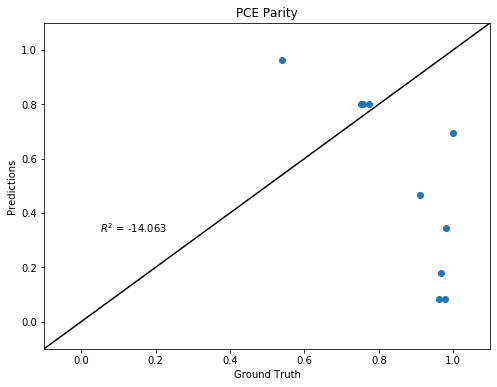

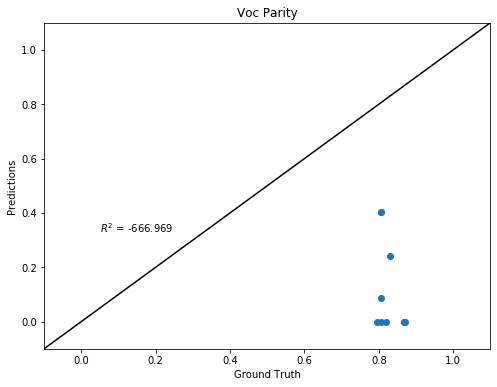

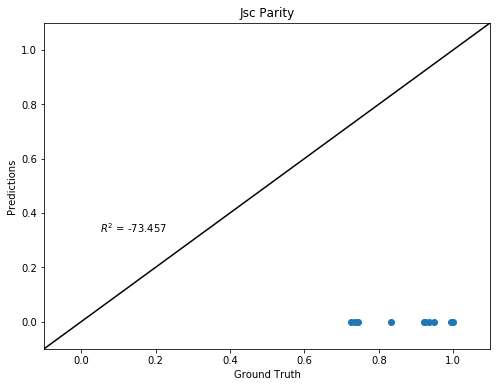

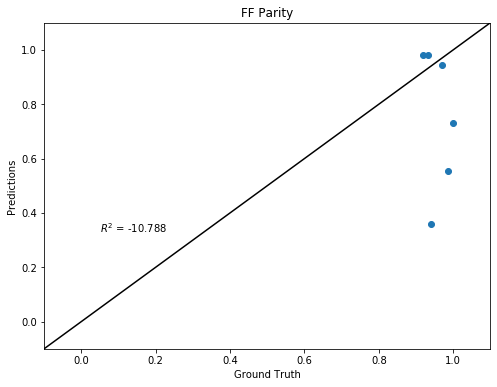

In [13]:
%autoreload

nuts.plot_OPV_parity(pce_labels, PCE_out, voc_labels, Voc_out,
                    jsc_labels, Jsc_out, ff_labels, FF_out)